# HW5 - Text classification with an RNN
### 0858610 周承翰
參考連結:https://www.tensorflow.org/tutorials/text/text_classification_rnn

### Setup

In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow_datasets as tfds
import tensorflow as tf

In [5]:
import tensorflow as tf
tf.__version__
#若為2.0.0-rc1 則無法model.fit

'2.0.0'

In [6]:
tf.test.is_gpu_available()

True

### import matplotlib and create a helper function to plot graphs:

In [4]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string], '')
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

### Setup input pipeline
The IMDB large movie review dataset is a binary classification dataset—all the reviews have either a positive or negative sentiment.<br />

Download the dataset using TFDS.<br />

使用tfds.load load 資料imdb


In [5]:
dataset, info = tfds.load('imdb_reviews/subwords8k',
                          shuffle_files=True,
                          with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

The dataset info includes the encoder (a tfds.features.text.SubwordTextEncoder).

In [6]:
encoder = info.features['text'].encoder

In [7]:
print ('Vocabulary size: {}'.format(encoder.vocab_size))


Vocabulary size: 8185


This text encoder will reversibly encode any string, falling back to byte-encoding if necessary.


In [8]:
sample_string = 'Hello TensorFlow.'

encoded_string = encoder.encode(sample_string)
print ('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print ('The original string: "{}"'.format(original_string))

Encoded string is [4025, 222, 6307, 2327, 4043, 2120, 7975]
The original string: "Hello TensorFlow."


In [9]:
# 檢查跟原始字串有沒有一樣
assert original_string == sample_string

In [10]:
for index in encoded_string:
  print ('{} ----> {}'.format(index, encoder.decode([index])))

4025 ----> Hell
222 ----> o 
6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
7975 ----> .


### Prepare the data for training
Next create batches of these encoded strings. Use the padded_batch method to zero-pad the sequences to the length of the longest string n the batch:<br />

Dataset.shuffle() 與 tf.RandomShuffleQueue使用相同的算法對資料夾隨機shuffle：它有一個固定大小的buffer，并從該buffer中随机均匀地選擇下一個元素 <br />
Dataset.padded_batch() 允許你將不同shape的tensors進行batch，通过指定一或多个dimensions，在其上进行pad。

In [11]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [12]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE, train_dataset.output_shapes)

test_dataset = test_dataset.padded_batch(BATCH_SIZE, test_dataset.output_shapes)


### Create the model

In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [14]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

### Training Model

In [15]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset, 
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 63s 160ms/step - loss: 0.6529 - accuracy: 0.6019 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
391/391 [==============================] - 58s 149ms/step - loss: 0.3849 - accuracy: 0.8402 - val_loss: 0.3679 - val_accuracy: 0.8411
Epoch 3/10
391/391 [==============================] - 57s 147ms/step - loss: 0.2619 - accuracy: 0.9002 - val_loss: 0.3150 - val_accuracy: 0.8651
Epoch 4/10
391/391 [==============================] - 58s 147ms/step - loss: 0.2149 - accuracy: 0.9242 - val_loss: 0.3247 - val_accuracy: 0.8729
Epoch 5/10
391/391 [==============================] - 57s 146ms/step - loss: 0.1881 - accuracy: 0.9342 - val_loss: 0.3318 - val_accuracy: 0.8651
Epoch 6/10
391/391 [==============================] - 57s 146ms/step - loss: 0.1724 - accuracy: 0.9402 - val_loss: 0.3349 - val_accuracy: 0.8729
Epoch 7/10
391/391 [==============================] - 58s 147ms/step - loss: 0.1506 - accuracy: 0.9504 - val_loss: 0.3555 

In [17]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 26s 66ms/step - loss: 0.4571 - accuracy: 0.8589
Test Loss: 0.4570928862713792
Test Accuracy: 0.8589199781417847


The above model does not mask the padding applied to the sequences. This can lead to skew if trained on padded sequences and test on un-padded sequences. Ideally you would use masking to avoid this, but as you can see below it only have a small effect on the output.

If the prediction is >= 0.5, it is positive else it is negative.

### Mask the padding

In [18]:
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

In [19]:
def sample_predict(sentence, pad):
  encoded_sample_pred_text = encoder.encode(sample_pred_text)

  if pad:
    encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
  predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))

  return (predictions)

In [20]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print (predictions)

[[0.41923377]]


In [21]:
# predict on a sample text with padding

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print (predictions)

[[0.3690635]]


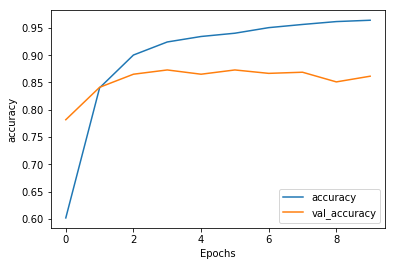

In [22]:
plot_graphs(history, 'accuracy')

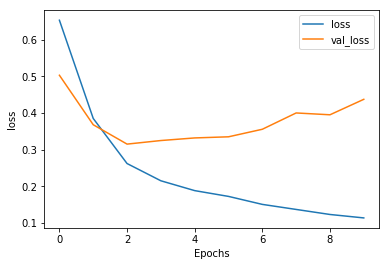

In [24]:
plot_graphs(history, 'loss')

### Stack two or more LSTM layers
Keras recurrent layers have two available modes that are controlled by the return_sequences constructor argument:

。Return either the full sequences of successive outputs for each timestep (a 3D tensor of shape (batch_size, timesteps, output_features)).<br />
。Return only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)).

In [25]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [26]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [27]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 108s 275ms/step - loss: 0.6460 - accuracy: 0.5913 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
391/391 [==============================] - 101s 259ms/step - loss: 0.3606 - accuracy: 0.8578 - val_loss: 0.3563 - val_accuracy: 0.8542
Epoch 3/10
391/391 [==============================] - 101s 259ms/step - loss: 0.2649 - accuracy: 0.9070 - val_loss: 0.3260 - val_accuracy: 0.8635
Epoch 4/10
391/391 [==============================] - 102s 260ms/step - loss: 0.2210 - accuracy: 0.9252 - val_loss: 0.3939 - val_accuracy: 0.8245
Epoch 5/10
391/391 [==============================] - 101s 259ms/step - loss: 0.1874 - accuracy: 0.9393 - val_loss: 0.3548 - val_accuracy: 0.8677
Epoch 6/10
391/391 [==============================] - 101s 259ms/step - loss: 0.1625 - accuracy: 0.9506 - val_loss: 0.3907 - val_accuracy: 0.8630
Epoch 7/10
391/391 [==============================] - 102s 260ms/step - loss: 0.1397 - accuracy: 0.9593 - val_loss: 

In [28]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 46s 118ms/step - loss: 0.4971 - accuracy: 0.8570
Test Loss: 0.4971338246408326
Test Accuracy: 0.8570399880409241


In [29]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print (predictions)

[[0.14433104]]


In [30]:
# predict on a sample text with padding

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print (predictions)

[[0.07568926]]


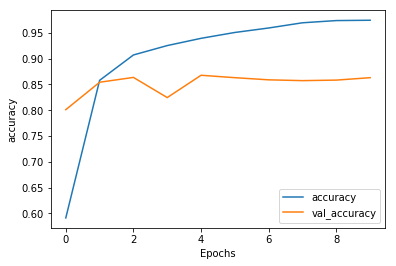

In [31]:
plot_graphs(history, 'accuracy')

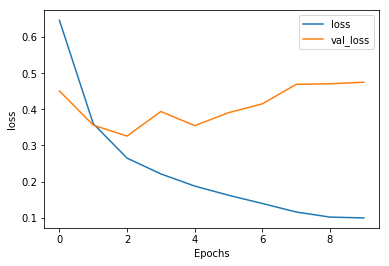

In [32]:
plot_graphs(history, 'loss')